<a href="https://colab.research.google.com/github/AnnaBozhenko/ML_course/blob/master/03_pyTorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt


In [2]:
# import clothes dataset
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data",
                                  train=False,
                                  download=True,
                                  transform=ToTensor(),
                                  target_transform=None)

100%|██████████| 26421880/26421880 [00:04<00:00, 6421738.75it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 362601.00it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4924945.46it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15131238.26it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
class_names = train_data.classes
[print(f"{class_names[i]} = {i}") for i in range(len(class_names))]

T-shirt/top = 0
Trouser = 1
Pullover = 2
Dress = 3
Coat = 4
Sandal = 5
Shirt = 6
Sneaker = 7
Bag = 8
Ankle boot = 9


[None, None, None, None, None, None, None, None, None, None]

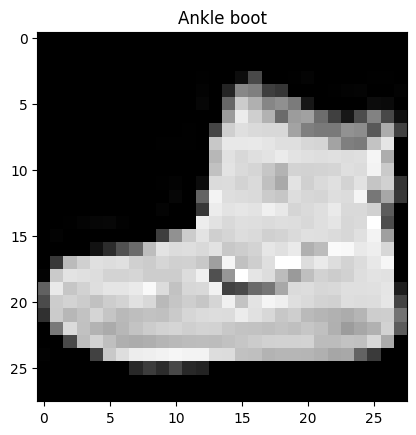

In [4]:
image, train_label = train_data[0]
plt.title(f"{class_names[train_label]}")
plt.imshow(image.squeeze(), cmap="gray")


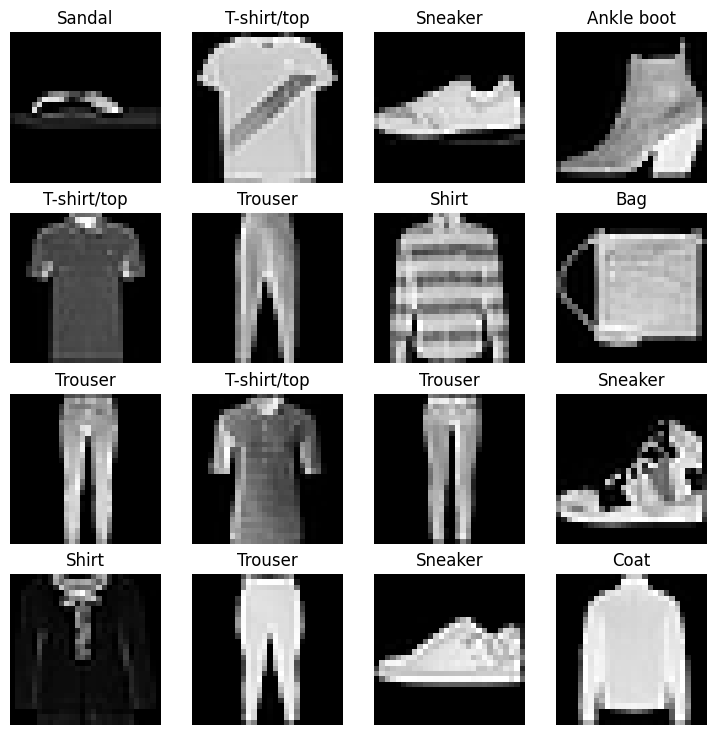

In [5]:
fig = plt.figure(figsize=(9, 9))
rows, columns = 4, 4
for i in range(1, rows * columns + 1):
    item_label_idx = torch.randint(0, len(train_data), size=[1]).item()
    item_image, item_label_idx = train_data[item_label_idx]
    item_label = class_names[item_label_idx]

    fig.add_subplot(rows, columns, i)
    plt.title(item_label)
    plt.imshow(item_image.squeeze(), cmap="gray")
    plt.axis(False)

# Divide training dataset on 32 batches

In [6]:
from torch.utils.data import DataLoader

In [7]:
BATCH_SIZE = 32

In [8]:
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)


In [9]:
test_data_loader = DataLoader(dataset=test_data,
                               batch_size=BATCH_SIZE,
                               shuffle=False)


# Example of a pick from train_data batch

In [10]:
# visualise batch item
train_dataloader_images, train_dataloader_labels_idxs = next(iter(test_data_loader))



(-0.5, 27.5, 27.5, -0.5)

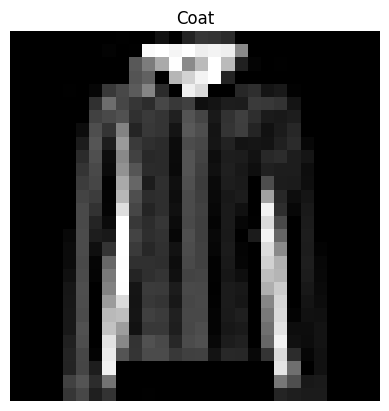

In [11]:
torch.manual_seed(42)

item_idx = torch.randint(0, len(train_dataloader_images), size=[1]).item()
image, label_idx = train_dataloader_images[item_idx], train_dataloader_labels_idxs[item_idx]

plt.title(class_names[label_idx])
plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")

# Create model

In [12]:
flatten_model = nn.Flatten()

x = train_dataloader_images[0]
output = flatten_model(x)

In [13]:
output.shape

torch.Size([1, 784])

In [14]:
class FashionMNISTModel_V0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.layers(x)


In [15]:
torch.manual_seed(42)

INPUT_FEATURES = 28*28
OUTPUT_FEATURES = len(class_names)
HIDDEN_FEATURES = 10
device_model_0 = "cpu"
model_0 = FashionMNISTModel_V0(input_features=INPUT_FEATURES,
                               output_features=OUTPUT_FEATURES,
                               hidden_units=HIDDEN_FEATURES).to(device_model_0)

In [16]:
model_0

FashionMNISTModel_V0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [17]:
# example of forward pass on dummy data
dummy_batch = torch.rand([1, 1, 28, 28]).to(device_model_0)
model_0(dummy_batch)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

# Setting up loss, optomisation and accuracy functions

In [18]:
from pathlib import Path
import requests

if not Path("helper_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [19]:
from helper_functions import accuracy_fn


In [20]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
from timeit import default_timer as timer

def measure_process_exec(time_start,
                         time_end,
                         device: torch.device = None):
  exec_time = time_end - time_start
  print(f"execution time: {exec_time:.3f} on device {device}")
  return exec_time

In [22]:
from tqdm.auto import tqdm

In [23]:
epochs_n = 3
start_epoch_n = 0
end_epoch_n = start_epoch_n + epochs_n
test_step = 400

In [24]:
torch.manual_seed(43)

traininig_start_time = timer()

for epoch in tqdm(range(start_epoch_n, end_epoch_n)):
  model_0.train()
  train_loss = 0
  for batch, (X_train, y_train) in enumerate(train_data_loader):
    train_preds = model_0(X_train.to(device_model_0))

    loss = loss_fn(train_preds, y_train.to(device_model_0))
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"{batch*len(X_train)}/{len(train_data_loader.dataset)} training data processed")

  train_loss /= len(train_data_loader)

  # test for every other n step
  # if epoch % 10 == 0:
  model_0.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X_test, y_test in test_data_loader:
      test_preds = model_0(X_test.to(device_model_0))
      loss = loss_fn(test_preds, y_test.to(device_model_0))
      test_loss += loss

      acc = accuracy_fn(y_true=y_test.to(device_model_0),
                        y_pred=test_preds.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  print(f"train loss: {train_loss:.2f}, test loss: {test_loss:.2f}, test accuracy: {test_acc:.2f}%")

traininig_end_time = timer()
training_duration_time = measure_process_exec(time_start=traininig_start_time,
                                              time_end=traininig_end_time,
                                              device=str(next(model_0.parameters()).device))

start_epoch_n = end_epoch_n
end_epoch_n += epochs_n


  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.59, test loss: 0.51, test accuracy: 82.27%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.47, test loss: 0.49, test accuracy: 82.52%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.45, test loss: 0.51, test accuracy: 82.43%
execution time: 35.851 on device cpu


In [25]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  model_0.eval()
  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device_model_0), y_test.to(device_model_0)

      test_preds = model(X_test)
      loss = loss_fn(test_preds, y_test)
      test_loss += loss

      acc = accuracy_fn(y_true=y_test,
                        y_pred=test_preds.argmax(dim=1))
      test_acc += acc

    test_loss /= len(test_data_loader)
    test_acc /= len(test_data_loader)

  return {"test_loss": test_loss,
          "test_accuracy": test_acc,
          "model_name": model.__class__.__name__}




automate train cycle

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [27]:
def train_model(model: nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn: nn.Module = None,
                device: torch.device = device,
                random_seed=43,
                batch_n_step_to_report=400):
  torch.manual_seed(random_seed)

  model.train()
  train_loss, train_accuracy = 0, 0

  for batch, (X_train, y_train) in enumerate(data_loader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    train_preds = model(X_train)
    loss = loss_fn(train_preds, y_train)
    train_loss += loss

    if accuracy_fn is not None:
      train_accuracy += accuracy_fn(y_true=y_train,
                                    y_pred=train_preds.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % batch_n_step_to_report == 0:
      print(f"{batch*len(X_train)}/{len(data_loader.dataset)} training data processed")

  train_loss /= len(data_loader)

  if train_accuracy > 0:
    train_accuracy /= len(data_loader)

  print(f"train loss: {train_loss:.2f}, train accuracy: {train_accuracy:.2f}%")
  return {"train_loss": train_loss,
          "train_accuracy": train_accuracy}


automate test cycle

In [28]:
def test_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               device: torch.device = device):
  model.eval()
  test_loss, test_accuracy = 0, 0

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_preds = model(X_test)
      loss = loss_fn(test_preds, y_test)
      test_loss += loss

      acc = accuracy_fn(y_true=y_test,
                        y_pred=test_preds.argmax(dim=1))
      test_accuracy += acc

    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)

  print(f"test loss: {test_loss:.2f}, test accuracy: {test_accuracy:.2f}%")
  return {"test_loss": test_loss,
          "test_accuracy": test_accuracy}


In [29]:
# setup device-agnostic code
torch.cuda.is_available()

False

train and test model_0

In [30]:
torch.manual_seed(43)

epochs_n = 3
test_step = 3
traininig_start_time = timer()

for epoch in tqdm(range(epochs_n)):
  train_model(model=model_0,
              data_loader=train_data_loader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)

  if epoch % (test_step - 1) == 0:
    test_model(model=model_0,
               data_loader=test_data_loader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

traininig_end_time = timer()
training_model_0_time = measure_process_exec(time_start=traininig_start_time,
                                              time_end=traininig_end_time,
                                              device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.44, train accuracy: 84.53%
test loss: 0.48, test accuracy: 83.28%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.43, train accuracy: 84.82%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.43, train accuracy: 84.99%
test loss: 0.48, test accuracy: 83.15%
execution time: 32.958 on device cpu


<!-- !nvidia-smi -->

evaluate model_0

In [31]:
model_0_evaluation = eval_model(model=model_0,
                                data_loader=test_data_loader,
                                loss_fn=loss_fn,
                                accuracy_fn=accuracy_fn)


# Implement class and functionalize training and testing loop

In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [33]:
class FashionMNIST_V1(nn.Module):
  def __init__(self,
               input_features,
               output_features,
               hidden_features):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_features,
                  out_features=hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_features,
                  out_features=output_features),
        nn.ReLU()
    )

  def forward(self, x):
    return self.layers(x)



In [34]:
model_1 = FashionMNIST_V1(input_features=28*28,
                          output_features=len(class_names),
                          hidden_features=10).to(device)

Set loss and optimise functions

In [35]:
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.1)

training and testing data

In [36]:
from timeit import default_timer as timer

In [37]:
epochs_n = 3
test_step = 3

In [38]:
device

'cpu'

In [39]:
start_training_time = timer()

for epoch in tqdm(range(epochs_n)):
  train_model(model_1,
              train_data_loader,
              loss_fn,
              optimizer,
              accuracy_fn)
  if (epoch + 1) % test_step == 0:
    test_model(model_1,
              test_data_loader,
              loss_fn,
              accuracy_fn)

end_training_time = timer()
training_model_1_time = measure_process_exec(time_start=start_training_time,
                                             time_end=end_training_time,
                                             device=str(next(model_0.parameters()).device))

print(f"training duration: {training_model_1_time}")

  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.70, train accuracy: 76.60%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.47, train accuracy: 83.34%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.44, train accuracy: 84.28%
test loss: 0.48, test accuracy: 83.21%
execution time: 32.937 on device cpu
training duration: 32.937393173000004


In [40]:
# evaluate the model
model_1_evaluation = eval_model(model_1,
                                test_data_loader,
                                loss_fn,
                                accuracy_fn)

print(model_1_evaluation)

{'test_loss': tensor(0.4832), 'test_accuracy': 83.20686900958466, 'model_name': 'FashionMNIST_V1'}


# Creating a CNN model

In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
class FashionMNIST_V2(nn.Module):
  def __init__(self,
               input_features,
               output_features,
               hidden_units):
    super().__init__()

    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_features,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classification = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_features)
    )

  def forward(self, x):
    # print(f"shape of input: {x.shape}")
    x = self.block_1(x)
    # print(f"shape of layer after 1st batch traversal: {x.shape}")
    x = self.block_2(x)
    # print(f"shape of layer after 2st batch traversal: {x.shape}")
    x = self.classification(x)
    # print(f"shape of layer after classification: {x.shape}")
    return x


In [43]:
torch.manual_seed(43)

model_2 = FashionMNIST_V2(input_features=1,
                          output_features=len(class_names),
                          hidden_units=10).to(device)
model_2

FashionMNIST_V2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Dummy convolutional and pool layers traversal

In [44]:
next(model_2.parameters()).device

device(type='cpu')

In [45]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[-0.0307, -0.2023,  0.2807],
                        [-0.1025, -0.2346, -0.2761],
                        [ 0.0606, -0.2894,  0.1651]]],
              
              
                      [[[ 0.0835,  0.2928, -0.2441],
                        [ 0.0127,  0.0224,  0.0250],
                        [ 0.1372, -0.0483, -0.1493]]],
              
              
                      [[[ 0.2264, -0.2292, -0.2619],
                        [ 0.1508, -0.1173,  0.2595],
                        [-0.2455,  0.2250,  0.0417]]],
              
              
                      [[[-0.0574,  0.2414, -0.1471],
                        [ 0.0556, -0.1142,  0.1182],
                        [ 0.1364,  0.2805, -0.1775]]],
              
              
                      [[[ 0.0838, -0.0251,  0.2437],
                        [-0.2204, -0.1144,  0.2442],
                        [ 0.1300, -0.0899,  0.1043]]],
              
              
           

In [46]:
# test conv2d on randon data

torch.manual_seed(32)

data = torch.randn([32, 3, 64, 64])
data[0].shape

torch.Size([3, 64, 64])

In [47]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=24,
                       kernel_size=3,
                       stride=1,
                       padding=0)

pass_trhough_conv_layer = conv_layer(data[0].unsqueeze(0))

In [48]:
maxpool_layer = nn.MaxPool2d(kernel_size=2)

pass_throught_maxPool_layer = maxpool_layer(pass_trhough_conv_layer)

In [49]:
print(f"shape (pass_trhough_conv_layer): {pass_trhough_conv_layer.shape}")
print(f"shape (pass_throught_maxPool_layer): {pass_throught_maxPool_layer.shape}")

shape (pass_trhough_conv_layer): torch.Size([1, 24, 62, 62])
shape (pass_throught_maxPool_layer): torch.Size([1, 24, 31, 31])


In [50]:
# test training o dummy data
torch.manual_seed(43)

rand_idx = torch.randint(0, len(train_data_loader), size=[1]).item()
image, image_label_idx = train_data_loader.dataset[rand_idx]
image = image.to(device)
class_names[image_label_idx]

'Sneaker'

In [51]:
image.device

device(type='cpu')

(-0.5, 27.5, 27.5, -0.5)

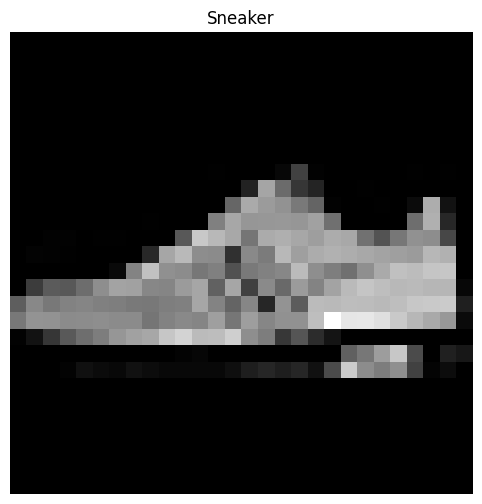

In [52]:
plt.figure(figsize=(12, 6))
plt.title(class_names[image_label_idx])
plt.imshow(image.cpu().squeeze(), cmap="gray")
plt.axis("off")

In [53]:
trained_data = model_2(image.unsqueeze(dim=0))


In [54]:
pred = trained_data.softmax(dim=1).argmax(dim=1)
pred

tensor(4)

In [55]:
class_names[pred]

'Coat'

Set loss and optimiser functions for CNN version of Fashion

In [56]:
# import helper_functions' acuracy_fn()
from pathlib import Path
import requests

if not Path("helper_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)


In [57]:
from helper_functions import accuracy_fn


In [58]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_2.parameters(),
                           lr=0.1)


In [59]:
# enable progress bar for tracking execution of training and testiond processes
from tqdm import tqdm

In [60]:
from timeit import default_timer as timer

In [61]:
device

'cpu'

In [62]:
# training and testing

epochs_n = 3
test_step=3
training_start_time = timer()

for epoch in tqdm(range(epochs_n)):
  train_model(model=model_2,
              data_loader=train_data_loader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)

  if (epoch + 1) % test_step == 0:
    test_model(model=model_2,
               data_loader=test_data_loader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

training_end_time = timer()
training_model_2_time = measure_process_exec(time_start=training_start_time,
                                             time_end=training_end_time,
                                             device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed


 33%|███▎      | 1/3 [00:52<01:45, 52.64s/it]

train loss: 0.61, train accuracy: 77.89%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed


 67%|██████▋   | 2/3 [01:42<00:51, 51.07s/it]

train loss: 0.36, train accuracy: 87.14%
0/60000 training data processed
12800/60000 training data processed
25600/60000 training data processed
38400/60000 training data processed
51200/60000 training data processed
train loss: 0.32, train accuracy: 88.58%


100%|██████████| 3/3 [02:35<00:00, 51.96s/it]

test loss: 0.33, test accuracy: 87.74%
execution time: 155.888 on device cpu


In [63]:
model_2_evaluation = eval_model(model_2,
                             test_data_loader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

In [64]:
model_0_evaluation

{'test_loss': tensor(0.4773),
 'test_accuracy': 83.14696485623003,
 'model_name': 'FashionMNISTModel_V0'}

In [65]:
import pandas as pd

In [66]:
models_performance = pd.DataFrame([model_0_evaluation, model_1_evaluation, model_2_evaluation])

In [67]:
models_performance

,test_loss,test_accuracy,model_name
0,tensor(0.4773),83.146965,FashionMNISTModel_V0
1,tensor(0.4832),83.206869,FashionMNIST_V1
2,tensor(0.3336),87.739617,FashionMNIST_V2


In [68]:
models_performance = models_performance.astype({"test_loss": float})

In [69]:
models_performance

,test_loss,test_accuracy,model_name
0,0.477264,83.146965,FashionMNISTModel_V0
1,0.483179,83.206869,FashionMNIST_V1
2,0.333551,87.739617,FashionMNIST_V2


In [70]:
models_performance = models_performance.assign(execution_time=[training_model_0_time, training_model_1_time, training_model_2_time])

In [71]:
models_performance

,test_loss,test_accuracy,model_name,execution_time
0,0.477264,83.146965,FashionMNISTModel_V0,32.958446
1,0.483179,83.206869,FashionMNIST_V1,32.937393
2,0.333551,87.739617,FashionMNIST_V2,155.887729


<Axes: ylabel='model_name'>

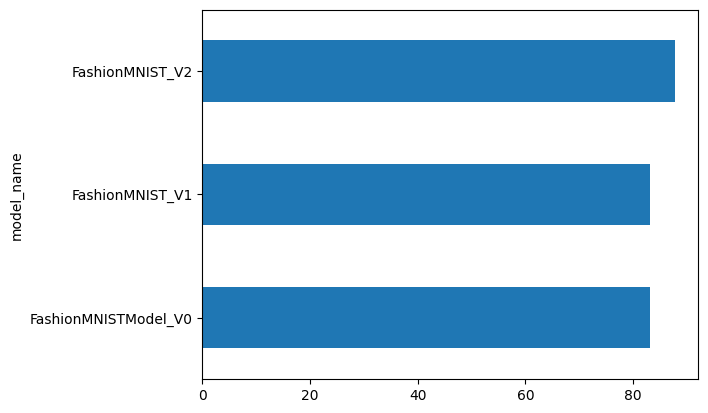

In [72]:
models_performance.set_index("model_name")["test_accuracy"].plot.barh()

Predict on random samples of data

In [73]:
# pick a random batch from testing sample
SAMPLES_N = 16

random_batch_idx = torch.randint(0, len(train_data_loader), size=[SAMPLES_N])
samples = [train_data_loader.dataset[idx] for idx in random_batch_idx]

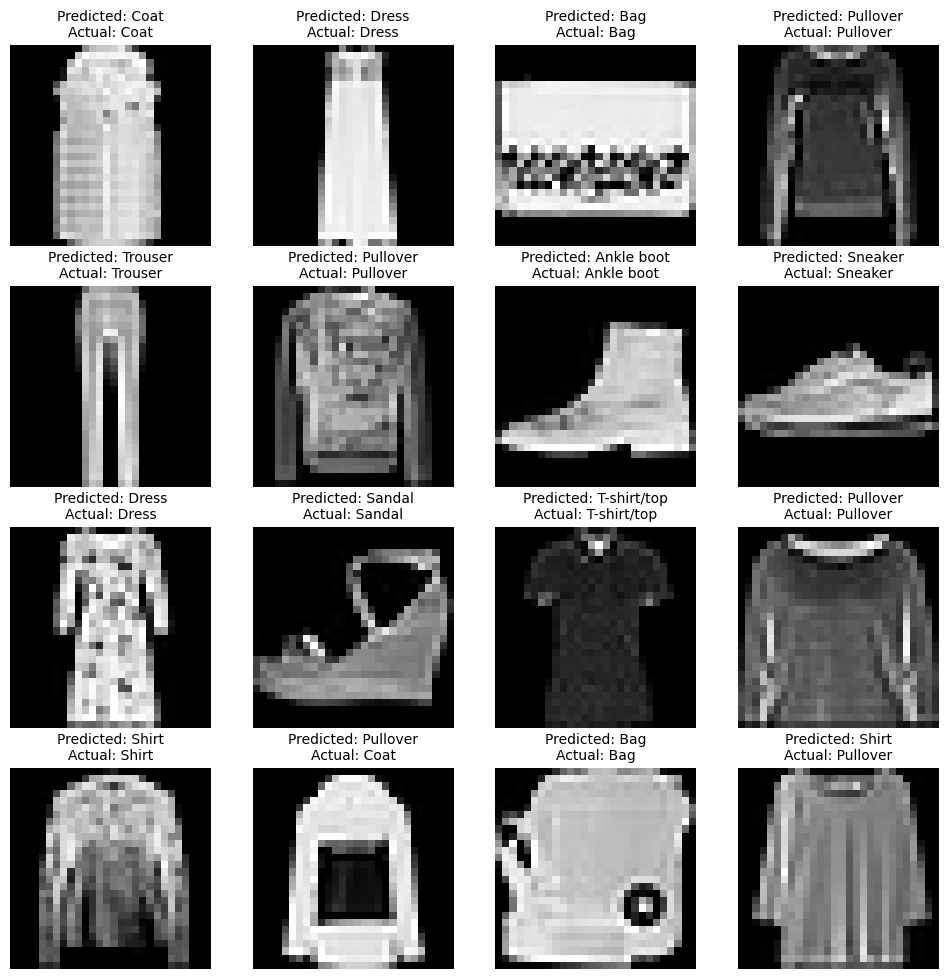

In [74]:
predictions = [model_2(image.unsqueeze(0)).softmax(dim=1).argmax(dim=1) for image, _ in samples]

fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for i in range(1, (rows * cols) + 1):
  fig.add_subplot(rows, cols, i)
  plt.imshow(samples[i-1][0].squeeze(), cmap="gray")
  plt.axis("off")
  plt.title(f"Predicted: {class_names[predictions[i-1]]}\nActual: {class_names[samples[i-1][1]]}", fontsize=10)


In [176]:
import random
random.seed(43)

images, labels = [], []
for image, label_idx in random.sample(list(test_data), k=16):
  images.append(image)
  labels.append(label_idx)

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [175]:
def predict_on_data(model: nn.Module,
                    dataset: list,
                    device=torch.device):
  model.eval()
  with torch.inference_mode():
    predictions = [model(image.to(device).unsqueeze(dim=0)).softmax(dim=1).argmax(dim=1) for image in dataset]

  return torch.cat(predictions)


In [177]:
# get predictions
predictions = predict_on_data(model=model_2,
                              dataset=images,
                              device=device)

In [178]:
predictions

tensor([4, 2, 0, 4, 5, 5, 0, 7, 5, 0, 6, 5, 2, 9, 1, 6])

In [179]:
def plot_predictions(images,
                     predictions,
                     actual_data,
                     cols=4):
  rows = len(images) // cols
  #
  plt.figure(figsize=(12, 12))
  for i in range(cols * rows):
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    color = "green" if predictions[i] == actual_data[i] else "red"
    plt.title(f"Predicted: {class_names[predictions[i]]} \nActual: {class_names[actual_data[i]]}", c=color, fontsize=10)
    plt.axis("off")


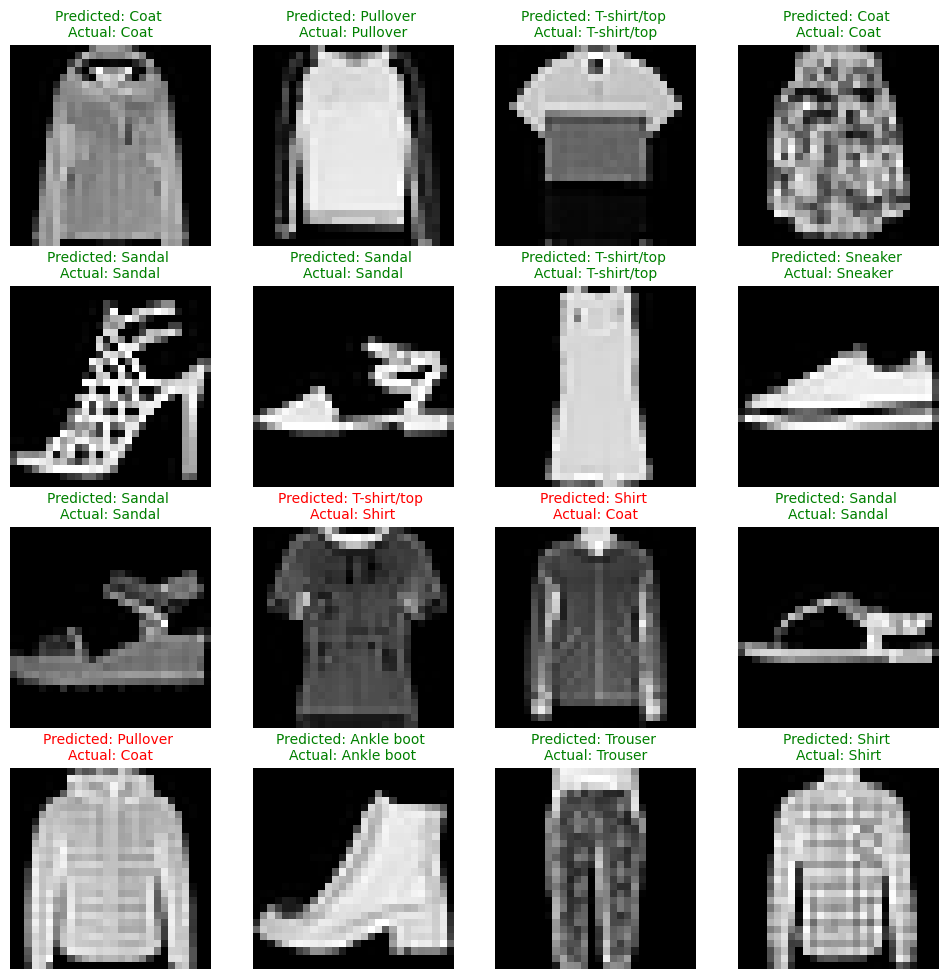

In [180]:
plot_predictions(images,
                 predictions,
                 labels)

In [146]:
import mlxtend, torchmetrics

In [172]:
from tqdm import tqdm

# test_predictions_model_0 = []
model_2.eval()
with torch.inference_mode():
  test_predictions = [model_2(image.to(device)).softmax(dim=1).argmax(dim=1) for image, y in tqdm(test_data_loader)]

test_predictions_2 = torch.cat(test_predictions)

100%|██████████| 313/313 [00:09<00:00, 33.65it/s]


In [173]:
test_predictions_2.shape

torch.Size([10000])

In [163]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

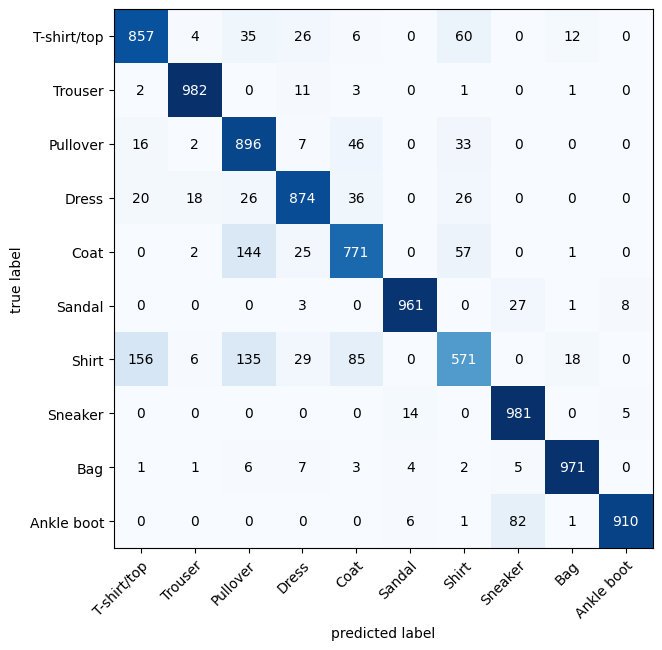

In [174]:
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task="multiclass")
confmat_tensor = confmat(preds=test_predictions_2,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

# Save the model

In [182]:
from pathlib import Path


In [185]:
MODULE_PATH_NAME ="Models"
module_path = Path(MODULE_PATH_NAME)
module_path.mkdir(parents=True, exist_ok=True)

FILE_NAME = "01_pyTorch_computer_vision_model_tiny_VGG.pth"
model_save_name = module_path / FILE_NAME
torch.save(obj=model_2.state_dict(),
           f=model_save_name)

In [ ]:
!ls -l Models

In [187]:
# load the saved model
model_v2_loaded = FashionMNIST_V2(input_features=1,
                                  output_features=len(class_names),
                                  hidden_units=10)

model_v2_loaded.load_state_dict(torch.load(f=model_save_name))
model_v2_loaded.to(device)

FashionMNIST_V2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [189]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_v2_loaded.parameters(),
                            lr=0.1)

In [190]:
# evaluate the loaded model
eval_model(model=model_v2_loaded,
           data_loader=test_data_loader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn)

{'test_loss': tensor(0.3336),
 'test_accuracy': 87.73961661341853,
 'model_name': 'FashionMNIST_V2'}